<a href="https://colab.research.google.com/github/bindersarah/Fly-Brain-Image-Processing/blob/main/DSLT_10_29_24ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import h5py
import cv2
import tempfile
import imageio
import pandas as pd
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import plotly.express as px

import plotly.io as pio
pio.renderers.default = 'browser'

## Transform h5j files to numpy arrays

In [2]:
def extract_channel(raw_data, nframes, height, width):
    with tempfile.NamedTemporaryFile(delete=True, suffix='.mp4') as temp_file:
        temp_file.write(raw_data)
        temp_file_name = temp_file.name

        # Create a reader object for the temporary file
        reader = imageio.get_reader(temp_file_name, 'ffmpeg')
        frames = np.empty((nframes, height, width), np.uint8)
        for i in range(nframes):
            frames[i] = reader.get_data(i)[:,:,0]
    return frames

def read_h5j(filename):
    with h5py.File(filename, 'r') as h5file:
        attributes = {}
        for tmp in h5file.attrs:
            attributes[tmp] = h5file.attrs[tmp]
        channel_attributes = {}
        for tmp in h5file['Channels'].attrs:
            channel_attributes[tmp] = h5file['Channels'].attrs[tmp]
        nframes = channel_attributes['frames'][0]
        height = channel_attributes['height'][0] + channel_attributes['pad_bottom'][0]
        width = channel_attributes['width'][0] + channel_attributes['pad_right'][0]
        R = extract_channel(h5file["Channels"]['Channel_0'][()].tobytes(), nframes, height, width)
        G = extract_channel(h5file["Channels"]['Channel_1'][()].tobytes(), nframes, height, width)
        B = extract_channel(h5file["Channels"]['Channel_2'][()].tobytes(), nframes, height, width)
        RGB = np.concatenate((R[:,:,:,None], G[:,:,:,None], B[:,:,:,None]), axis = 3)              #create array of pixels per RBG
        reference = extract_channel(h5file["Channels"]['Channel_3'][()].tobytes(), nframes, height, width)
    return RGB, reference, attributes


Sample Brain Image

In [ ]:
# upload to colab if needed

#RGB, reference, attributes = read_h5j('/R27C09-20181221_62_F1-f-40x-central-GAL4-JRC2018_FEMALE_40x-aligned_stack.h5j')

 #'R27C09-20181221_62_F1-f-40x-central-GAL4-JRC2018_FEMALE_40x-aligned_stack.h5j')

## Load test Image: 2D Image, 17 x 17 subsection

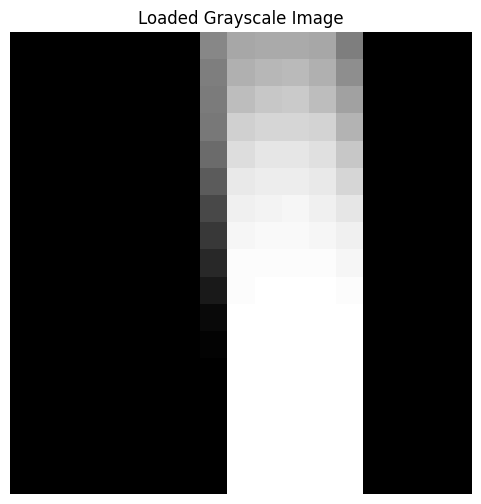

In [4]:
image = cv2.imread('dslt_test.jpg')

# ensure in grayscale
if len(image.shape) == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# resize
image = cv2.resize(image, (203,270)) #203 x 270 pixels

# select 17 x 17 pixel
image1 = image[90-8:90+9, 100-8:100+9]

# Display the loaded image
plt.figure(figsize=(6, 6))
plt.title("Loaded Grayscale Image")
plt.imshow(image1, cmap='gray')
plt.axis('off')
plt.show()

# create coordinate grid 17 x 17
X,Y = np.meshgrid(np.arange(-8,9), np.arange(-8,9))

# Rotate Image

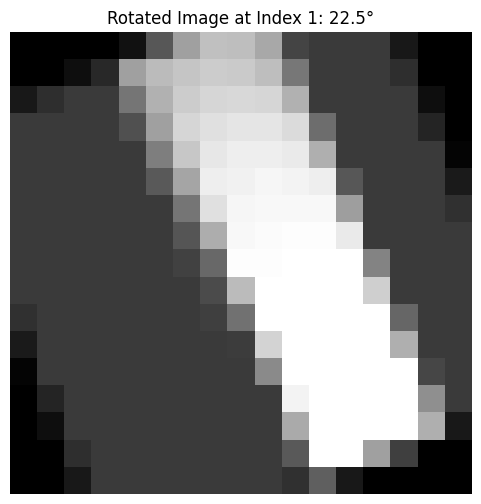

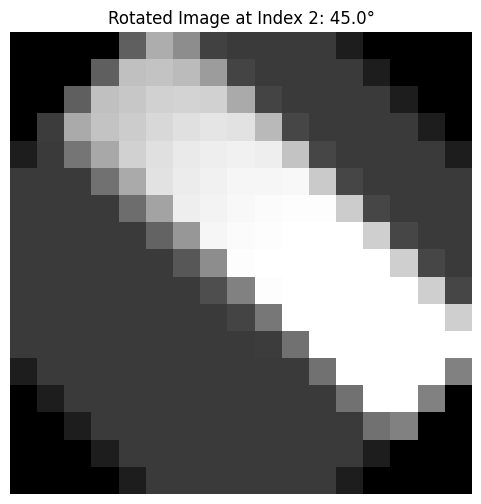

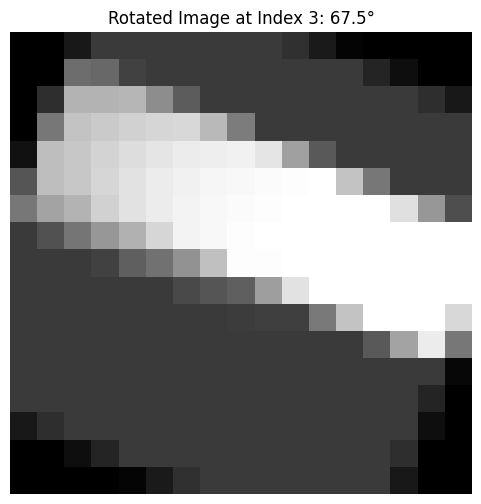

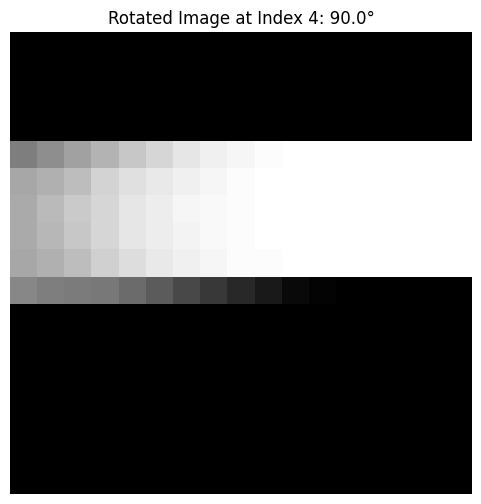

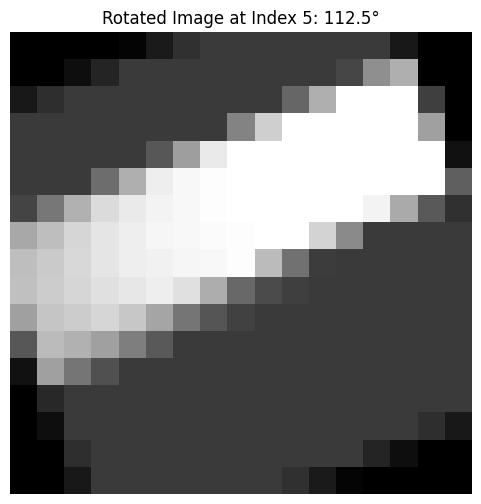

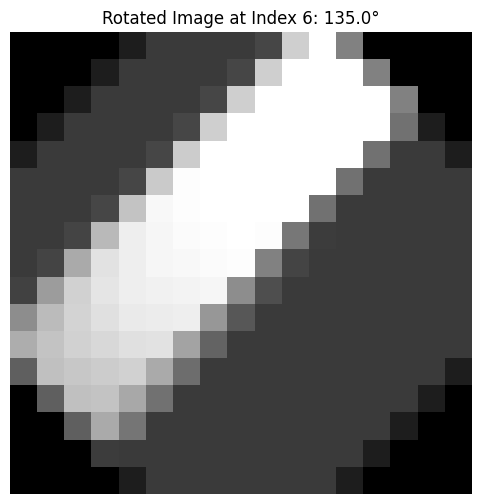

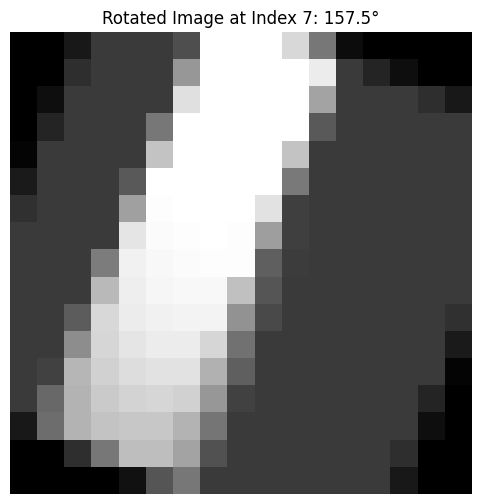

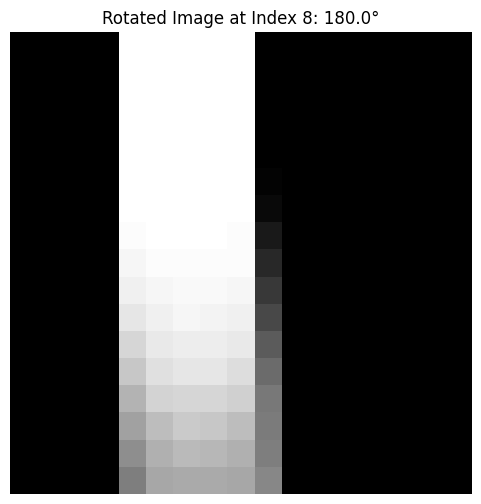

In [5]:
# Loop to rotate image1 8 different ways (first subsection)

# define standard variables
(X, Y) = image1.shape[:2]
center = (Y // 2, X // 2)
scale = 1.0
angles_list = [22.5, 45.0, 67.5, 90.0, 112.5, 135.0, 157.5, 180.0]

# Turn into Function
def image_rotate(image):
  for index, angle in enumerate(angles_list):
    # define matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

    # rotate image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (Y, X))# rotate #**** change image1

    # Display the rotated image
    plt.figure(figsize=(6, 6))
    plt.title(f"Rotated Image at Index {index + 1}: {angle}°")
    plt.imshow(rotated_image, cmap='gray')
    plt.axis('off')
    plt.show()

# run function on dslt test image
image_rotate(image1)

# Gaussian Weights

Gaussian weights:  [6.69162896e-05 4.36349021e-04 2.21596317e-03 8.76430436e-03
 2.69959580e-02 6.47599366e-02 1.20987490e-01 1.76035759e-01
 1.99474648e-01 1.76035759e-01 1.20987490e-01 6.47599366e-02
 2.69959580e-02 8.76430436e-03 2.21596317e-03 4.36349021e-04
 6.69162896e-05]
1.0


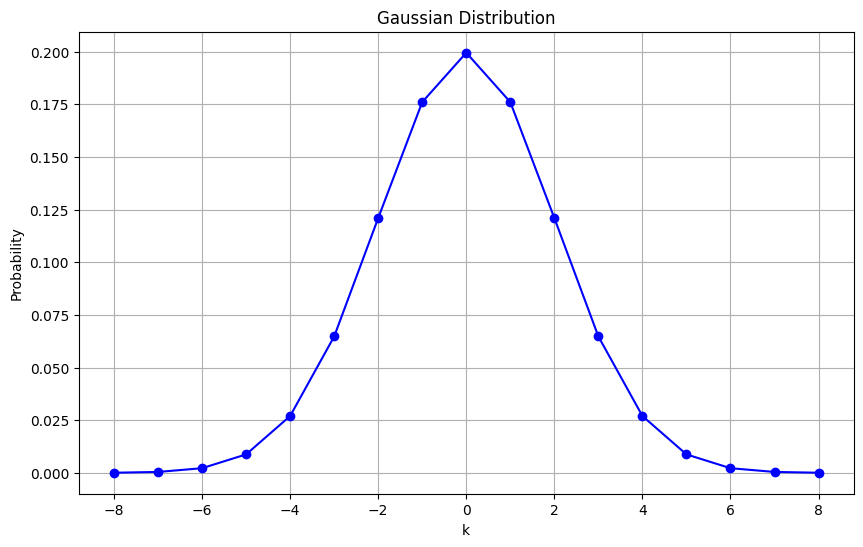

In [6]:
# Define the Gaussian weight function
def gaussian_weights(size, sigma=2):
    k = np.arange(-size // 2 + 1, size // 2 + 1)
    weights = np.exp(-(k**2) / (2 *sigma*2)) ## coded wrong - as k*2

# normalize to ensure values sum to 1
# gaussian = gaussian / np.sum(gaussian)

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.plot(k, weights / weights.sum(), 'b-o') # b-o = blue, solid line, circles
    plt.title('Gaussian Distribution')
    plt.xlabel('k')
    plt.ylabel('Probability')
    plt.grid(True)

    return weights / weights.sum()  # Normalize so that the sum is 1
    return plt.show()

# Generate weights for a 17-pixel row
gaussian_weights_1d = gaussian_weights(17)
print("Gaussian weights: ", gaussian_weights_1d)

# ensure weights sum to 1
print(np.sum(gaussian_weights_1d)) # 1.0

# Calculate Threshold

###1. Compute weighted pixels: center row pixels values * gaussian weights
###2. Compute weighted sums per rotation
###3. Compute Threshold by summing all 8 weighted sums

In [7]:
# Define the angles list (already provided earlier)
angles_list = [22.5, 45.0, 67.5, 90.0, 112.5, 135.0, 157.5, 180.0]

# Initialize a list to store weighted sums for each angle
weighted_sums = []

# Loop through all the rotation angles and calculate weighted sums
for angle in angles_list:
    # Perform the rotation
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
    rotated_image1 = cv2.warpAffine(image1, rotation_matrix, (Y, X))

    # Extract the pixel values along the x-axis (center row)
    center_row_pixels = rotated_image1[8, :]  # Extract the 17 pixels from the rotated image

    # Apply Gaussian weights
    weighted_pixels = center_row_pixels * gaussian_weights_1d  # A * B

    # Compute the weighted sum and store the result
    weighted_sum = np.sum(weighted_pixels)
    weighted_sums.append(weighted_sum)

# Sum all the 8 weighted sums to compute the threshold
threshold_value = np.sum(weighted_sums)

# Output the threshold value
print("Threshold value from 8 rotations:", threshold_value)

Threshold value from 8 rotations: 652.0638089752538


# Calc Min Threshold?

In [8]:
# Constant value for the threshold comparison (set to 0 for now)
constant = 0

# Initialize an array to store all the threshold values for each rotation
thresholds = []

# Loop through all rotation angles and calculate the threshold for each rotation
for angle in angles_list:
    # Rotate the image
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
    rotated_image1 = cv2.warpAffine(image1, rotation_matrix, (Y, X))

    # Extract the center row of pixels (row 8, as it’s the center of the 17x17 window)
    center_row_pixels = rotated_image1[8, :]  # 17-pixel row

    # Apply Gaussian weights to the pixel values
    weighted_pixels = center_row_pixels * gaussian_weights_1d  # A * B

    # Calculate the weighted sum (threshold) for this angle
    threshold = np.sum(weighted_pixels)
    thresholds.append(threshold)

# Find the minimum threshold across the 8 angles
min_threshold = np.min(thresholds)

# Now apply the decision rule for the center pixel of the original image1
center_pixel_value = image1[8, 8]  # The center pixel of the original 17x17 window

# Apply the decision rule: compare center pixel to min_threshold + constant
if center_pixel_value > min_threshold + constant:
    output_value = 1  # The pixel exceeds the threshold
else:
    output_value = 0  # The pixel does not exceed the threshold

# Output the final decision
print("Center pixel value:", center_pixel_value)
print("Minimum threshold across angles:", min_threshold)
print("Output value (1 for feature, 0 for no feature):", output_value)

Center pixel value: 104
Minimum threshold across angles: 73.29477623652053
Output value (1 for feature, 0 for no feature): 1


# Skip: accomplished via process_image
## local_windows
#### To identify all 17x17 patches

In [ ]:
# Function to identify patches
def local_windows(image, patch_size=17):
    # Get the dimensions of the image
    img_height, img_width = image.shape

    # Create an output image (same size as input) initialized with zeros
    output_image = np.zeros_like(image)

    # for output threshold
    threshold = np.zeros_like(image)

    # output angle
    output_angle = np.zeros_like(image)

    # Loop through every pixel, excluding the border (as we can't crop a 17x17 patch around the borders)
    border = patch_size // 2
    for i in range(border, img_height - border):
        for j in range(border, img_width - border):
            # Crop a 17x17 patch around the current pixel (i, j)
            patch = image[i - border:i + border + 1, j - border:j + border + 1]

            # Process the patch and get the output value (1 or 0)
            output_threshold, angle = process_patch(patch, gaussian_weights_1d)
            threshold[i,j] = output_threshold
            output_angle[i,j] = angle

            # compare to min_threshold
            if image[i,j] > output_threshold + 2:
                output_image[i,j] = 1  # Feature detected


    return output_image, threshold, output_angle



# process_patch
#### To determine threshold for a single patch

In [9]:
# Define rotation angles
angles_list = [22.5, 45.0, 67.5, 90.0, 112.5, 135.0, 157.5, 180.0]

# Function to process a single 17x17 patch and evaluate the center pixel
def process_patch(patch, gaussian_weights_1d, constant=0):
    (X, Y) = patch.shape[:2]
    center = (Y // 2, X // 2)
    scale = 1.0
    weighted_sums = []

    # Rotate patch and calculate weighted sum for each angle
    for angle in angles_list:
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
        rotated_patch = cv2.warpAffine(patch, rotation_matrix, (Y, X))

        # Extract center row and apply Gaussian weights
        center_row_pixels = rotated_patch[8, :]
        weighted_pixels = center_row_pixels * gaussian_weights_1d
        weighted_sums.append(np.sum(weighted_pixels))

    # Determine minimum threshold from all rotations
    min_threshold = np.min(weighted_sums)

    # Evaluate if the center pixel exceeds the threshold
    center_pixel_value = patch[8, 8]
    return 1 if center_pixel_value > min_threshold else 0


# process_image

### define function

In [10]:
# Function to process the entire image
def process_image(image, patch_size=17):
    img_height, img_width = image.shape
    output_image = np.zeros_like(image)
    border = patch_size // 2

    # Loop through each pixel, skipping borders # identifies all patches
    for i in range(border, img_height - border):
        for j in range(border, img_width - border):
            # Extract 17x17 patch
            patch = image[i - border:i + border + 1, j - border:j + border + 1]

            # Process the patch and get result for the center pixel
            output_image[i, j] = process_patch(patch, gaussian_weights_1d)

    return output_image

### Apply to DSLT image

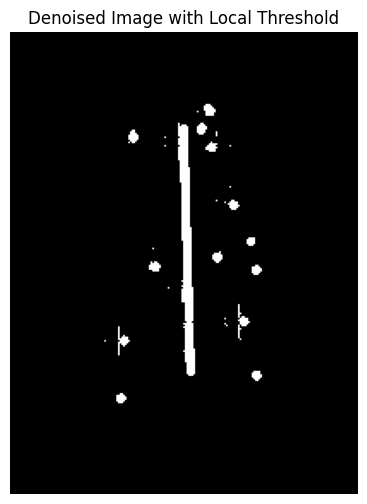

In [11]:
# Load and preprocess the image (ensure it’s grayscale)
image = cv2.imread('dslt_test.jpg', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: Could not load the image. Please check the file path.")
else:
    # Resize for testing purposes if needed
    image = cv2.resize(image, (203, 270))

    # Apply the image processing function
    output_image = process_image(image)

    # Display the processed image
    plt.figure(figsize=(6, 6))
    plt.title("Denoised Image with Local Threshold")
    plt.imshow(output_image, cmap='gray')
    plt.axis('off')
    plt.show()

### Define Local Windows Function

In [ ]:
# Function to identify patches
def local_windows(image, patch_size=17):
    # Get the dimensions of the image
    img_height, img_width = image.shape

    # Create an output image (same size as input) initialized with zeros
    output_image = np.zeros_like(image)

    # for output threshold
    threshold = np.zeros_like(image)

    # output angle
    output_angle = np.zeros_like(image)

    # Loop through every pixel, excluding the border (as we can't crop a 17x17 patch around the borders)
    border = patch_size // 2
    for i in range(border, img_height - border):
        for j in range(border, img_width - border):
            # Crop a 17x17 patch around the current pixel (i, j)
            patch = image[i - border:i + border + 1, j - border:j + border + 1]

            # Process the patch and get the output value (1 or 0)
            output_threshold, angle = process_patch(patch, gaussian_weights_1d)
            threshold[i,j] = output_threshold
            output_angle[i,j] = angle

            # compare to min_threshold
            if image[i,j] > output_threshold + 2:
                output_image[i,j] = 1  # Feature detected


    return output_image, threshold, output_angle



# Apply to Kawase Image

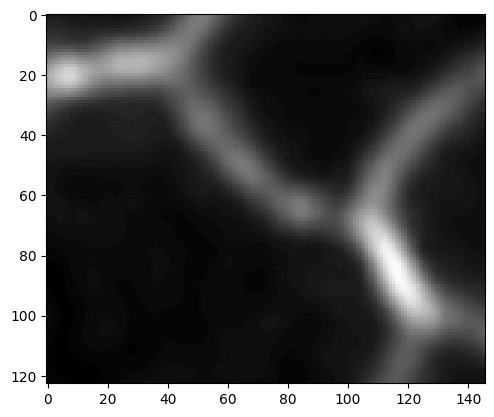

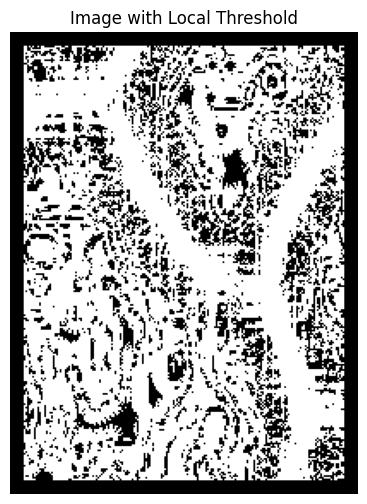

In [ ]:
# Load and preprocess the image (ensure it’s grayscale)
image = cv2.imread('kawase_image.png', cv2.IMREAD_GRAYSCALE)

# resize
image = cv2.resize(image, (146, 123))

#show
plt.imshow(image, cmap = 'gray')

# Check if the image was loaded correctly
if image is None:
    print("Error: Could not load the image. Please check the file path.")
else:
    # Resize for testing purposes if needed
    image = cv2.resize(image, (203, 270))

    # Apply the image processing function
    output_image = process_image(image) # process_image calls process_patch

    # Display the processed image
    plt.figure(figsize=(6, 6))
    plt.title("Image with Local Threshold")
    plt.imshow(output_image, cmap='gray')
    plt.axis('off')
    plt.show()

# Process

### 1. identify patches of 17x17 local windows
### 2. Calculate threshold per patch
### 3. Evaluate center pixel > min_threshold per local window

Next Steps:
10/25
1. Try other patches (with more signal) and evaluate weighted sums
2. Try equal weights 1/17 ...
3. Try Hough Transform: what is ouput, and what feature can we use to determine if there is a line through the center
10/29
See Notebook Yiyin Shared in Slack:
1. Try plotting yellow lines like in Kawase image (see paper) check we have the same orientation as yellow lines
2. Play around with constant value ?

